* <font size="3"> This is the second file for Alfabattle 2.0. The goal of the competition was to predict client's default probability for a particular product based on transaction history.</font>


* <font size="3">This notebook contains all functions which I used for feature engineering during the Alfabattle 2.0. This file was downloaded from Google Colab, and all the workings were performed there.</font>



* <font size="3">The main peculiarity of this notebook is the lack of input arguments for almost all functions. Instead, I used "global" declaration, so that it was not necessary to copy 200+ MB files every time they are put into a function.</font>


* <font size="4">IMPORTANT!</font> <font size="3"> This notebook is rewrittent, since the one, in which I performed all the tasks, was not quite structured. In some places, where necessary, I will insert photos of some commands. </font>

# Import

In [2]:
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import jaccard_similarity_score
from numpy import nan_to_num
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Firstly, let's create a list of paths for all 50 files that we will need to process

In [ ]:
list_filenames = !ls "/content/drive/My Drive/train_trans_contest"
all_names_do25 = []
all_names_after_25 = []
for i in range(len(list_filenames)):
    d = list_filenames[i].split()
    all_names_do25.append(d[0])
    all_names_after_25.append(d[1])
all_names = all_names_do25 + all_names_after_25 #list_with_filepaths

* Then, let's upload a training file with target variable for every app_id and type of credit product

In [ ]:
train_target = pd.read_csv('/content/drive/My Drive/alfabattle2_train_target_contest.csv') #file with app_id of a client


* Since I don't have enough memory, we need to optimize its usage

In [ ]:
#THE FUNCTION BELOW IS NOT MINE AND WAS TAKEN FROM KAGGLE NOTEBOOK

#The only change that was made is "global" declaration of an input further file

def reduce_mem_usage():
    global file
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in (file.columns):
        if file[col].dtype != object:  # Exclude strings

            # make variables for Int, max and min
            IsInt = False
            col_max_value = file[col].max()
            col_min_value = file[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(file[col]).all(): 
                NAlist.append(col)
                file[col].fillna(col_min_value - 1, inplace=True)

            # test if column can be converted to an integer
            col_as_int = file[col].fillna(0).astype(np.int64)
            diff = (file[col] - col_as_int)
            diff = diff.sum()
            if np.abs(diff) < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if col_min_value >= 0:
                    if col_max_value < 255:
                        file[col] = file[col].astype(np.uint8)
                    elif col_max_value < 65535:
                        file[col] = file[col].astype(np.uint16)
                    elif col_max_value < 4294967295:
                        file[col] = file[col].astype(np.uint32)
                    else:
                        file[col] = file[col].astype(np.uint64)
                else:
                    if col_min_value > np.iinfo(np.int8).min and col_max_value < np.iinfo(np.int8).max:
                        file[col] = file[col].astype(np.int8)
                    elif col_min_value > np.iinfo(np.int16).min and col_max_value < np.iinfo(np.int16).max:
                        file[col] = file[col].astype(np.int16)
                    elif col_min_value > np.iinfo(np.int32).min and col_max_value < np.iinfo(np.int32).max:
                        file[col] = file[col].astype(np.int32)
                    elif col_min_value > np.iinfo(np.int64).min and col_max_value < np.iinfo(np.int64).max:
                        file[col] = file[col].astype(np.int64)    

            # Make float datatypes 32 bit
            else:
                file[col] = file[col].astype(np.float32)

    return NAlist

# Useful functions

In [ ]:
def return_thresholds():
    '''
    The function calculates threshold indexes for every unique app_id, so that it was convenient to make 
    slicing, for ex. file[a:b].
    
    :return thresholds, np.array
    '''
    global file
    thres = file.groupby('app_id').count()['transaction_number'].values #get the number of transactions for every app_id
    thres = np.array(list([0]) + list(thres))
    thres = np.cumsum(thres) #get indexes which will help separate every app_-d
    return thres

In [ ]:
def read_file(path_):
    '''
    More convenient way to read a parquet file
    :param path_: path to file
    :return: pandas DataFrame
    '''
    return pd.read_parquet('/content/drive/My Drive/train_trans_contest/'+ path_)

In [ ]:
def file_clean():
    '''
    Inplace cleaning of an input file. The function checks for anomalies in 2 binary regressors:
    'income_flag' and 'operation_type_group'. EDA has shown that these features have 3 unique values. 
    We detect the presence of outliers - anomalies - and drop such rows. At the same time we create a list
    with binary values - 1 if this client(app_id) had anomalies - and 0 otherwise. 
    
    Adds feature "anomalies" to the file with target.
    
    Converts all spendings sums to from positive to negative values.
    '''
    global file
    thres = return_thresholds()
    anomalies = []
    app_ids = [] #keep app_id fo further convenient merge
    for i in (range(1, len(thres))):
        l = thres[i-1]
        r = thres[i]
        temp_file = file[l:r]
        if len(temp_file) == 0: #in case indexes in threshold are the same (which happened once), we need to pass
            continue
        app_ids.append(temp_file['app_id'].unique()[0])
        len_ = len(temp_file[(temp_file['income_flag']==3)|(temp_file['operation_type_group']==3)])
        if len_ > 0:
            anomalies.append(1)
        else:
            anomalies.append(0)
        del temp_file
    file = file[(file['income_flag']!=3)&(file['operation_type_group']!=3)]
    #Add to file
    file = file.merge(pd.DataFrame(zip(app_ids, anomalies), columns=['app_id', 'anomalies']), on='app_id', how='outer')
    #As we have shown in EDA, income_flag = 1 - spendings.
    file.loc[file['income_flag']==1, 'amnt'] = -1*file[file['income_flag']==1]['amnt'] 
    
    del anomalies, app_ids
    

In [ ]:
def ration_days_oper():
    '''
    Introduces new binary feature - 'employed'. We suppose that employed people,
    who work Monday-Friday between 8:00-18:00 do not often make many purchases, since they don't have time for that.
    Therefore, ratio of such purchases to all purchases might be low. Since about 6.7% of people are unemployed
    in Russia, henceforth we consider people with high ratio (compared to 0.943 quantile) unemployed.
    
    :change: adds "employed" feature to train_target
    '''
    global file
    global train_target
    thres = return_thresholds()
    ratios = []
    app_ids = []
    for i in (range(1, len(thres))):
        l = thres[i-1]
        r = thres[i]
        temp_file = file[l:r]
        if len(temp_file) == 0: #
            continue
        #from EDA we think that 'day_of_week' = 2 or 3 - weekend.
        working_days = len(temp_file[(temp_file['hour'].isin(np.arange(8,19)))&temp_file['day_of_week'].isin([1,4,5,6,7])])
        ratios.append(working_days/len(temp_file))
        app_ids.append(temp_file['app_id'].unique()[0])
        del temp_file
    ratios = np.array(ratios)
    upper_bound = np.quantile(ratios, 0.943) 
    employed = (ratios < upper_bound)*1
    del thres, ratios
    train_target = train_target.merge(pd.DataFrame(zip(app_ids, employed), columns=['app_id', 'employed']), on='app_id', how='outer')
    gc.collect()

In [ ]:
def has_credit_and_debit_card():
    '''
    Adds 2 more features - possession of credit card and possesion of debit card.
    From EDA we know that 'operation_type_group' = 1 - credit card, and = 2 - debit card.
    
    :change: adds features "has_credit_card" and "has_debit_card" to train_target
    '''
    global file
    global train_target
    thres = return_thresholds()
    has_credit_card = []
    has_debit_card = []
    app_ids = []
    for i in (range(1, len(thres))):
        l = thres[i-1]
        r = thres[i]
        temp_file = file[l:r]
        if len(temp_file) == 0:
            continue
        app_ids.append(temp_file['app_id'].unique()[0])
        len_ = len(temp_file[temp_file['operation_type_group']==1])
        if len_ == 0:
            has_credit_card.append(0)
        else:
            has_credit_card.append(1)
        len_debit = len(temp_file[temp_file['operation_type_group']==2])
        if len_debit == 0:
            has_debit_card.append(0)
        else:
            has_debit_card.append(1)
        del temp_file
    del thres
    gc.collect()
    train_target = train_target.merge(pd.DataFrame(zip(app_ids, has_credit_card, has_debit_card), columns=['app_id', 'has_credit_card', 'has_debit_card']),
                                    on='app_id', how='outer')

In [ ]:
def count_mean_hour_diff():
    '''
    Calculate median and max statistics for every app_id of 'hour_diff' and
    max of 'days_before'. This idea was taken from the baseline, we consider it to be useful.
    
    :change: adds features "hour_diff_mean", 'hour_diff_max', 'days_before_max' to train_target
    '''
    global file
    global train_target
    
    d = pd.DataFrame(file.groupby('app_id').median()['hour_diff']).reset_index()
    d.columns = ['app_id', 'hour_diff_mean']
    train_target = train_target.merge(d, on='app_id', how='outer')

    f = pd.DataFrame(file.groupby('app_id').max()['hour_diff']).reset_index()
    f.columns = ['app_id', 'hour_diff_max']
    train_target = train_target.merge(f, on='app_id', how='outer')

    s = pd.DataFrame(file.groupby('app_id').max()['days_before']).reset_index()
    s.columns = ['app_id', 'days_before_max']
    train_target = train_target.merge(s, on='app_id', how='outer')

    del d, f, s
    gc.collect()

* <font size="3">The following function helps calculate $\frac{\Delta f}{\Delta t}$, where f = 'amnt'. We try to find a proxy for a change in time of client's transactions.</font>

In [ ]:
def mean_and_var_time_delta():
    '''
    :change: 'mean_time_delta' feature - mean of all values calculated using the formula above.
    :change: 'var_time_delta' feature - var of all values calculated using the formula above.
    :change: 'max_mean_delta' feature - mean of top-10 positive changes.
    :change: 'min_mean_delta' feature - mean of top-10 negative changes.
    '''
    global file
    global train_target
    means = []
    vars_ = []
    maxes = []
    mins = []
    app_ids = []
    thres = return_thresholds()
    for i in (range(1, len(thres))):
        l = thres[i-1]
        r = thres[i]
        temp_file = file[l:r]
        if len(temp_file) == 0:
            continue
        app_ids.append(temp_file['app_id'].unique()[0])
        amnt = temp_file['amnt'].values
        time = temp_file['hour_diff'].values
        delta = (amnt[1:]-amnt[:-1])/(time[1:]-time[:-1])
        delta = nan_to_num(delta, nan=0, posinf=0, neginf=0) #sometimes we encounter division by 0 - when 2 operations were made within an hour
        means.append(np.mean(delta))
        vars_.append(np.var(delta))
        max_mean = np.mean(np.sort(delta)[-10:])
        min_mean = np.mean(np.sort(delta)[:10])
        maxes.append(max_mean)
        mins.append(min_mean)
        del delta, temp_file
    train_target = train_target.merge(pd.DataFrame(zip(app_ids, means, vars_,maxes, mins), columns=['app_id', 
                                                                                                 'mean_time_delta', 'var_time_delta',
                                                                                                 'max_mean_delta', 'min_mean_delta']),
                                    on='app_id', how='outer')
    gc.collect()

In [ ]:
def final_nakop():
    '''
    Compute the cumulutive sum of all spendings and incomes. 
    
    :change: add feature "final_sum" - cumulative sum of a person at the moment of the last transaction.
    '''
    global file
    global train_target
    app_ids = []
    nakops = []
    thres = return_thresholds()
    for i in (range(1, len(thres))):
        l = thres[i-1]
        r = thres[i]
        temp_file = file[l:r]
        if len(temp_file) == 0:
            continue
        app_ids.append(temp_file['app_id'].unique()[0])
        cumsum = np.cumsum(temp_file['amnt']).values
        try:
            nakops.append(cumsum[-1])
        except:
            nakops.append(0)
        del temp_file, cumsum
    train_target = train_target.merge(pd.DataFrame(zip(app_ids, nakops), columns=['app_id', 'final_sum']),
                                    on = 'app_id', how = 'outer')
    gc.collect()

In [ ]:
def counting_means_for_columns():
    '''
    Create pivot table for specicified inside columns based on 'amnt' data. The aggfunction is 'mean'.
    
    :change: add mean value of amnt for every unique value of the following columns: 
    'operation_kind', 'operation_type_group', 'payment_system'.
    '''
    global file
    global train_target
    columns_to_pivot = ['operation_kind', 'operation_type_group', 'payment_system']
    for column in columns_to_pivot:
        dich = pd.pivot_table(file, values='amnt', index='app_id', columns=[column], aggfunc=['mean'], fill_value=0.0).reset_index()
        col_names = dich.columns
        true_names = []
        for i in range(len(col_names)):
            if i == 0:
                true_names.append('app_id')
            else:
                true_names.append(column+'_'+str(i)+'_mean')
    dich.columns = true_names
    train_target = train_target.merge(dich, on='app_id', how='outer')
    del dich
    gc.collect()

* Let's add a similar function

In [ ]:
def counting_count_for_columns():
    '''
    Create pivot table for specicified inside columns based on 'amnt' data. The aggfunction is 'count'.
    
    :change: add number of 'amnt' observations for every unique value of the following columns: 
    'operation_kind', 'operation_type_group', 'payment_system'.
    '''
    global file
    global train_target
    columns_to_pivot = ['operation_kind', 'operation_type_group', 'payment_system']
    for column in columns_to_pivot:
        dich = pd.pivot_table(file, values='amnt', index='app_id', columns=[column], aggfunc=['count'], fill_value=0.0).reset_index()
        col_names = dich.columns
        true_names = []
        for i in range(len(col_names)):
            if i == 0:
                true_names.append('app_id')
            else:
                true_names.append(column+'_'+str(i)+'_count')
    dich.columns = true_names
    train_target = train_target.merge(dich, on='app_id', how='outer')
    del dich
    gc.collect()

In [ ]:
def countring_var_for_city_country():
    '''
    Calculate variance of 'city' and 'country' for every unique app_id
    
    :change: add 'city' and 'country' - variance of values for every app_id
    '''  
    global file
    global train_target
    city_disp = pd.DataFrame(file.groupby(by='app_id').var()['city']).reset_index()
    country_disp = pd.DataFrame(file.groupby(by='app_id').var()['country']).reset_index()
    train_target = train_target.merge(city_disp, on='app_id', how='outer')
    train_target = train_target.merge(country_disp, on='app_id', how='outer')
    del country_disp, city_disp
    gc.collect()

In [ ]:
def income_ratio():
    '''
    Calculate ratio of number of income transactions to number of all transactions
    
    :change: add 'ratio_income_to_all'
    '''
    global file
    global train_target
    thres = return_thresholds()
    ratios_income = []
    app_ids = []
    for i in (range(1, len(thres))):
        l = thres[i-1]
        r = thres[i]
        temp_file = file[l:r]
        if len(temp_file) == 0:
            continue
        app_ids.append(temp_file['app_id'].unique()[0])
        ratios_income.append(len(temp_file[temp_file['income_flag']==2])/len(temp_file))
    train_target = train_target.merge(pd.DataFrame(zip(app_ids, ratios_income), columns=['app_id', 'ratio_income_to_all']),
                                    on = 'app_id', how = 'outer')
    del ratios_income, app_ids
    gc.collect()


In [ ]:
def dollar_and_euro_ratio():
    '''
    Calculate ratio of number of transactions in euro or dollar to number of all transactions. 
    
    :change: add 'ratio_euro_dollar'
    '''
    global file
    global train_target
    thres = return_thresholds()
    ratios_currencies = []
    app_ids = []
    for i in (range(1, len(thres))):
        l = thres[i-1]
        r = thres[i]
        temp_file = file[l:r]
        if len(temp_file) == 0:
            continue
        app_ids.append(temp_file['app_id'].unique()[0])
        ratios_currencies.append(len(temp_file[temp_file['currency'].isin([2,3])])/len(temp_file))
    train_target = train_target.merge(pd.DataFrame(zip(app_ids, ratios_currencies), columns=['app_id', 'ratio_euro_dollar']),
                                    on = 'app_id', how = 'inner')
    del ratios_currencies, app_ids
    gc.collect()
    

## Finally, let's put it all together into 1 function

In [ ]:
def make_features(path):
    global file
    global train_target
    file = read_file(path)
    list_ = reduce_mem_usage()
    file_clean()
    print('Starting doing')
    ration_days_oper()
    has_credit_and_debit_card()
    print('2 functions done')
    count_mean_hour_diff()
    mean_and_var_time_delta()
    print('4 functions done')
    final_nakop()
    counting_means_for_columns()
    print('6 functions done')
    countring_var_for_city_country()
    income_ratio()
    print('8 functions done')
    dollar_and_euro_ratio()
    counting_count_for_columns()
    print('all done')
    gc.collect()

## And one more function to preprocess it all

This will help me get rid of all files and keep only the features.  

In [ ]:
def make_target(names):
    global file
    global train_target
    for i in tqdm(range(len(all_names))):#len(all_names)
        train_target = pd.read_csv('/content/drive/My Drive/alfabattle2_test_target_contest.csv')
        make_features(names[i])
        train_target.to_csv('file_'+str(i)+'.csv')

In [ ]:
make_target(all_names)

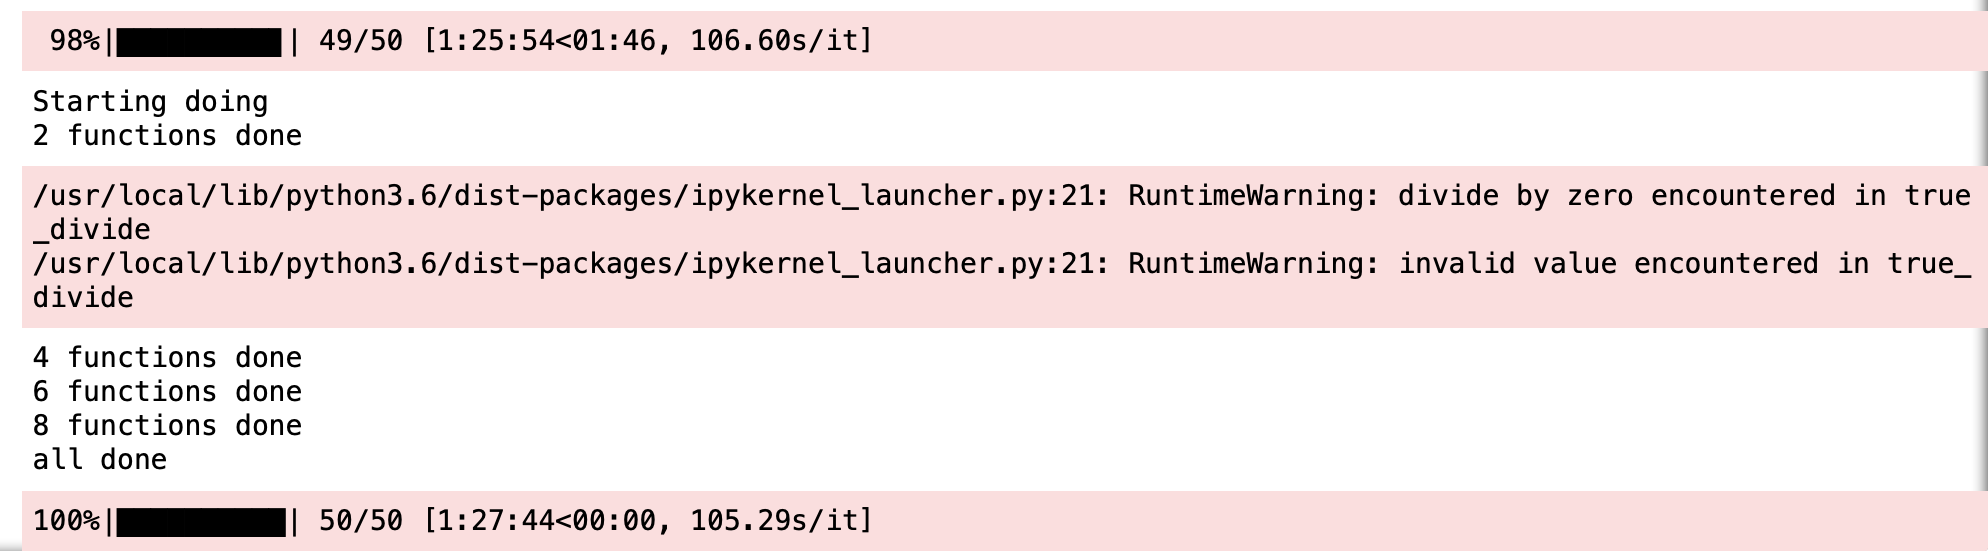

# Get it all back and prepare for GB

By this time, we have preprocessed all files with data. We need to upload them again, merge, fill some missing values and preprocess a little more

In [ ]:
for i in range(len(all_names)):
    if i == 0:
        train_target = pd.read_csv('file_0.csv', index_col='Unnamed: 0')
    else:
        train_target = pd.concat([train_target, pd.read_csv('file_'+str(i)+'.csv', index_col='Unnamed: 0')], axis=0)

In [ ]:
train_target.fillna(value=0, inplace=True)
train_target.set_index('app_id', inplace=True)

### Make OHE for categorical variable 'product'

In [ ]:
train_target = pd.concat([pd.get_dummies(train_target['product']), data.drop(columns='product')], axis=1)
train_target.head()

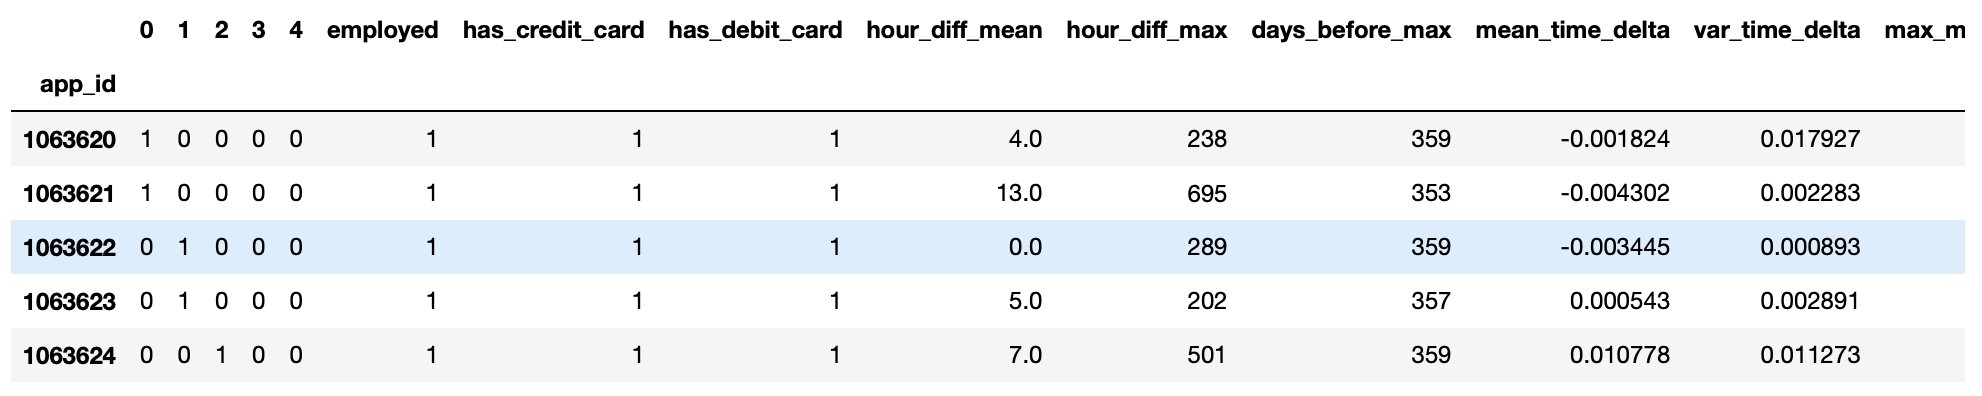

## Split and Scale data

* Since futher on I would like to find the best regularization lambda, it's essential to scale data. Moreover, this help understand the importance of features.

In [ ]:
X = train_target.drop(columns=['flag'])
y = train_target['flag']
del train_target
X.shape

In [ ]:
numeric_features = X.columns[8:]
not_to_scale = X.columns[:8] #columns which shouldn't be scaled

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features)
])

'''
I would like to scale the data and get it back to pandas DataFrame for convenience.
'''
f = column_transformer.fit_transform(X)

scaled_data = pd.DataFrame(f, columns=numeric_features)

index_x = X[not_to_scale].index
scaled_data = scaled_data.set_index(index_x)

X = pd.concat([X[not_to_scale], scaled_data], axis=1)
X

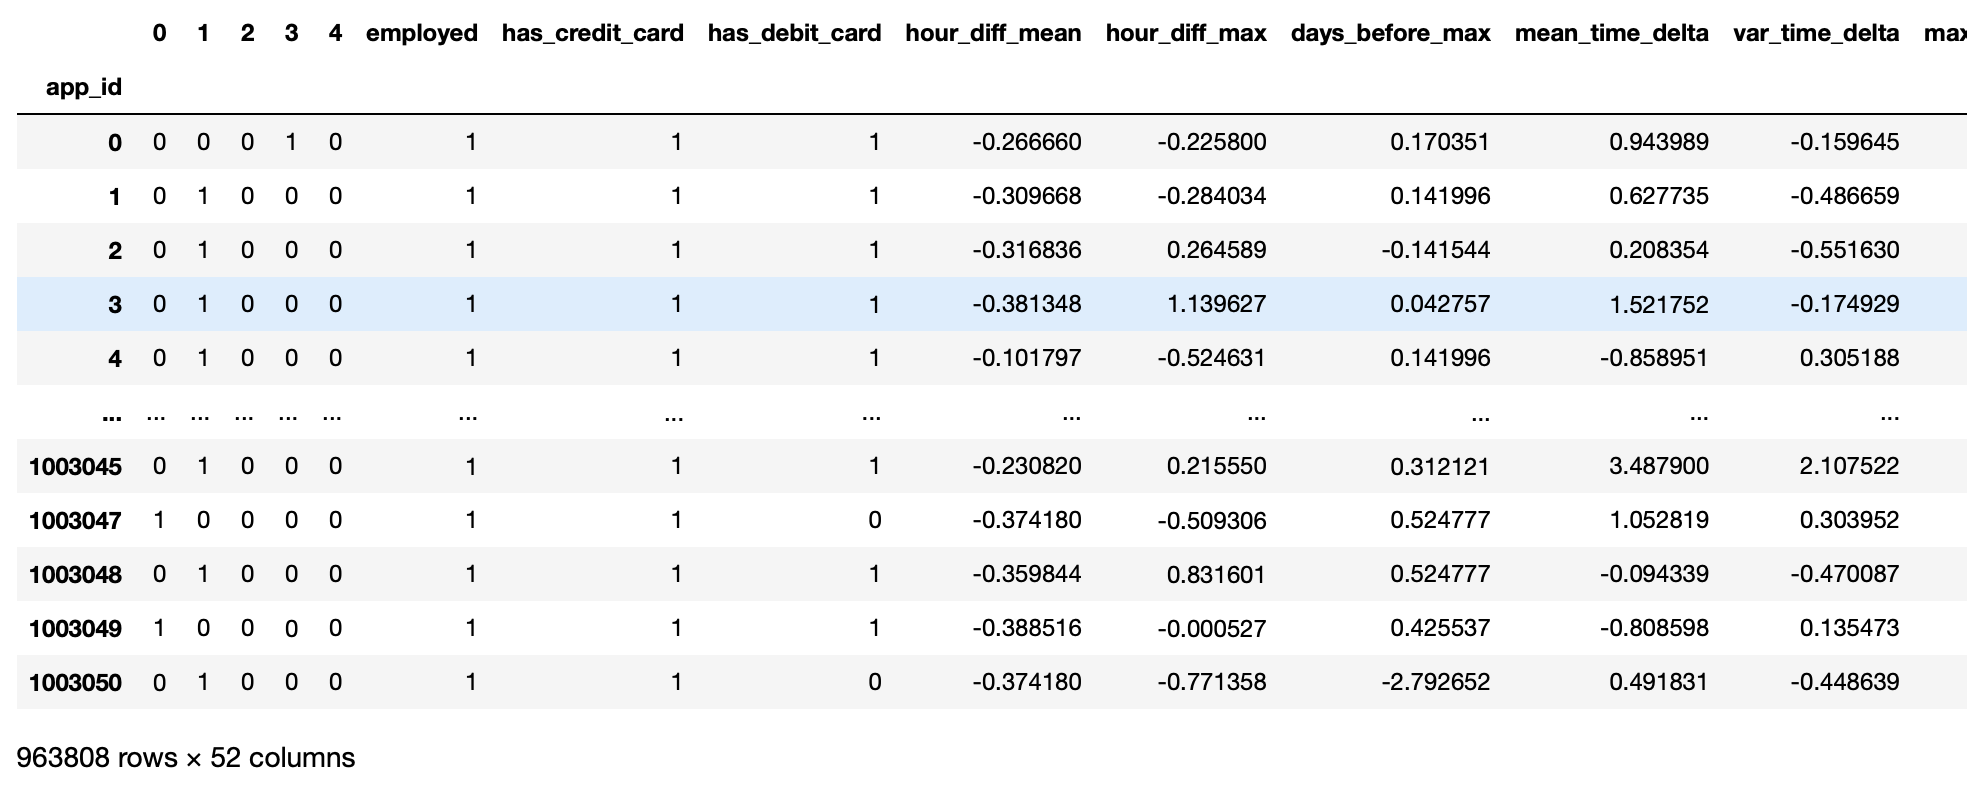

In [ ]:
del f, scaled_data

## Gradient Boosting

* We have achieved the final point. Right now we need to search for the best hyperparams. I have chosen catboost implementations since it works quite fast when using GPU (don't forget, I'm using Colab).

* Initial GridSearch included more hyperparams, but it was supposed to work more than 1 day. So I had to abandon that idea and restrict the area of searching.

In [ ]:
clf = CatBoostClassifier(iterations = 1200, eval_metric = 'AUC', task_type = 'GPU', loss_function='Logloss')
grid = {'n_estimators': np.arange(1000, 1300, 50),
        'learning_rate': [0.03],
        'max_depth': [4, 6, 8],
        'l2_leaf_reg': np.logspace(-3, 2, 7)}
grid_search_result = clf.grid_search(grid, 
                                       X=X, 
                                       y=y, 
                                       plot=True, verbose=True)

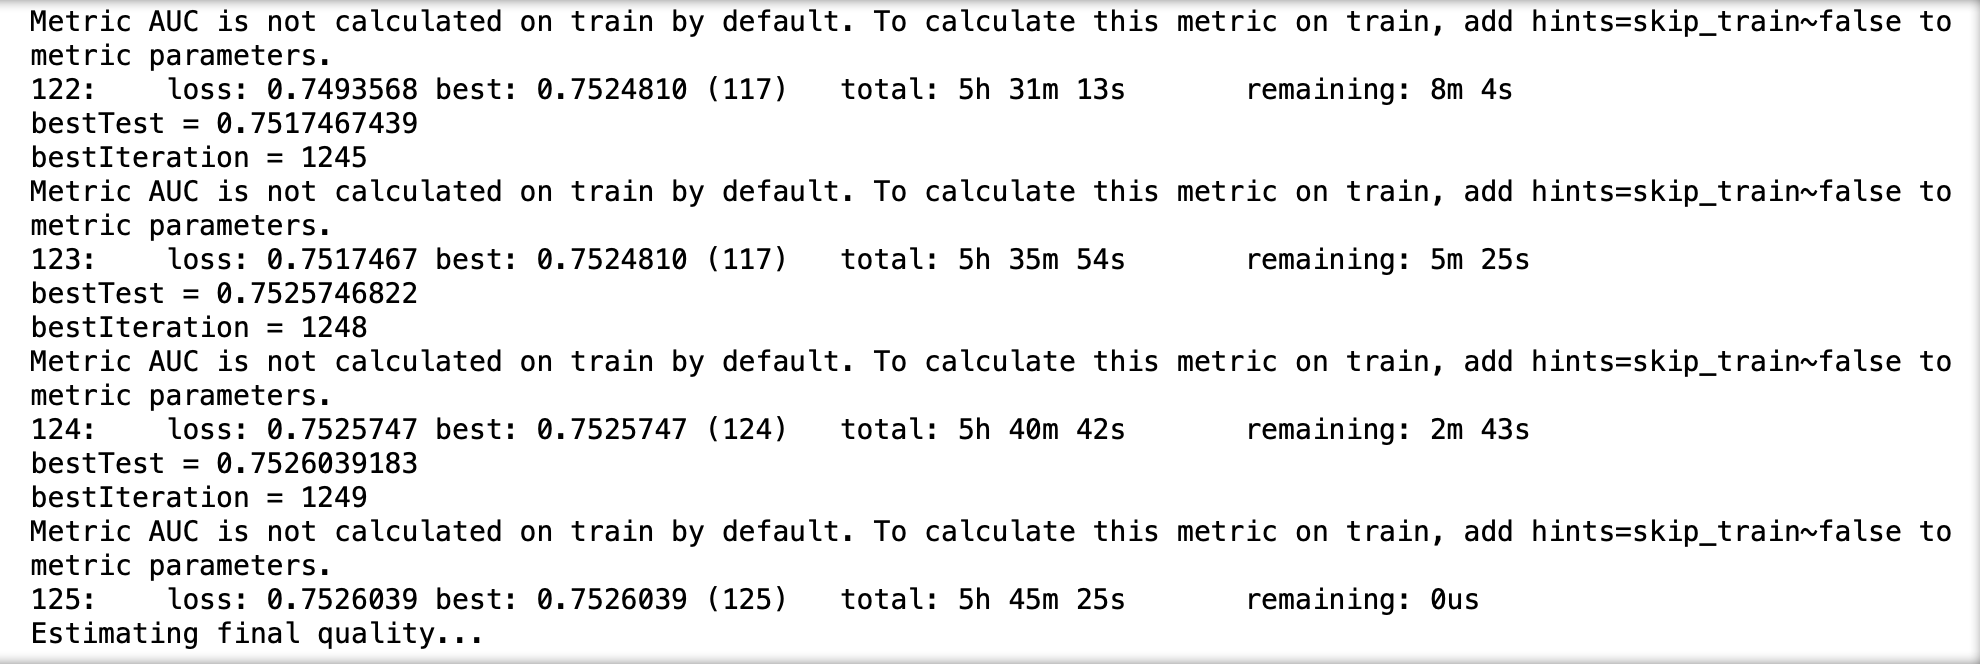

In [ ]:
grid_search_result['params']

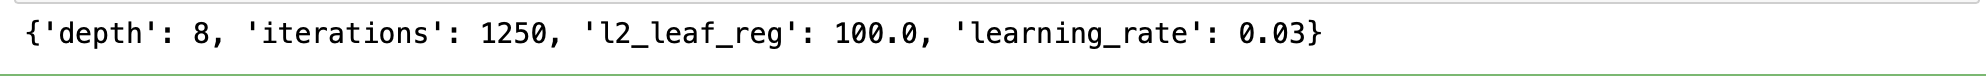

* <font size="3">It is quite surprising that the best l_2 regularization coefficient is so high. In fact, it is the biggest possible one in the gridsearch. Partially I can explain it due to quite big depth, but, nevertheless.</font>

* <font size="3"> Let's keep these results and create a model. </font>

* <font size="3"> I will implement a 7-fold cross-validation with the found earlier hyperparams. In between I will calculate ROC-AUC score in the train and CV data.

In [ ]:
from sklearn.model_selection import KFold
import catboost

tree_params = {
    'n_estimators': 1500,
    'max_depth': 8,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'random_state': 100,
    'l2_leaf_reg': 100,
    'task_type': 'GPU'
}


clf = CatBoostClassifier(iterations = 1250, **tree_params)
cv = KFold(n_splits=7, random_state=100, shuffle=True)

oof = np.zeros(len(y)) #for CV scores
train_preds = np.zeros(len(y)) #for train_scores

models = []

for fold_, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    print(f'Training with fold {fold_} started.')
    model = CatBoostClassifier(**tree_params)
    
    train_X, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_X, val_y = X.iloc[val_idx], y.iloc[val_idx]

    train_pool = catboost.Pool(train_X, train_y)
    val_pool = catboost.Pool(val_X, val_y)
  
    model.fit(train_pool, eval_set=[val_pool], early_stopping_rounds = 100,verbose_eval=50, use_best_model=True, plot=False)
    
    oof[val_idx] = model.predict_proba(val_pool)[:, 1]
    
    train_preds[train_idx] += model.predict_proba(train_pool)[:, 1] / (cv.n_splits-1)
    models.append(model)
    print(f'Training with fold {fold_} completed.')
    

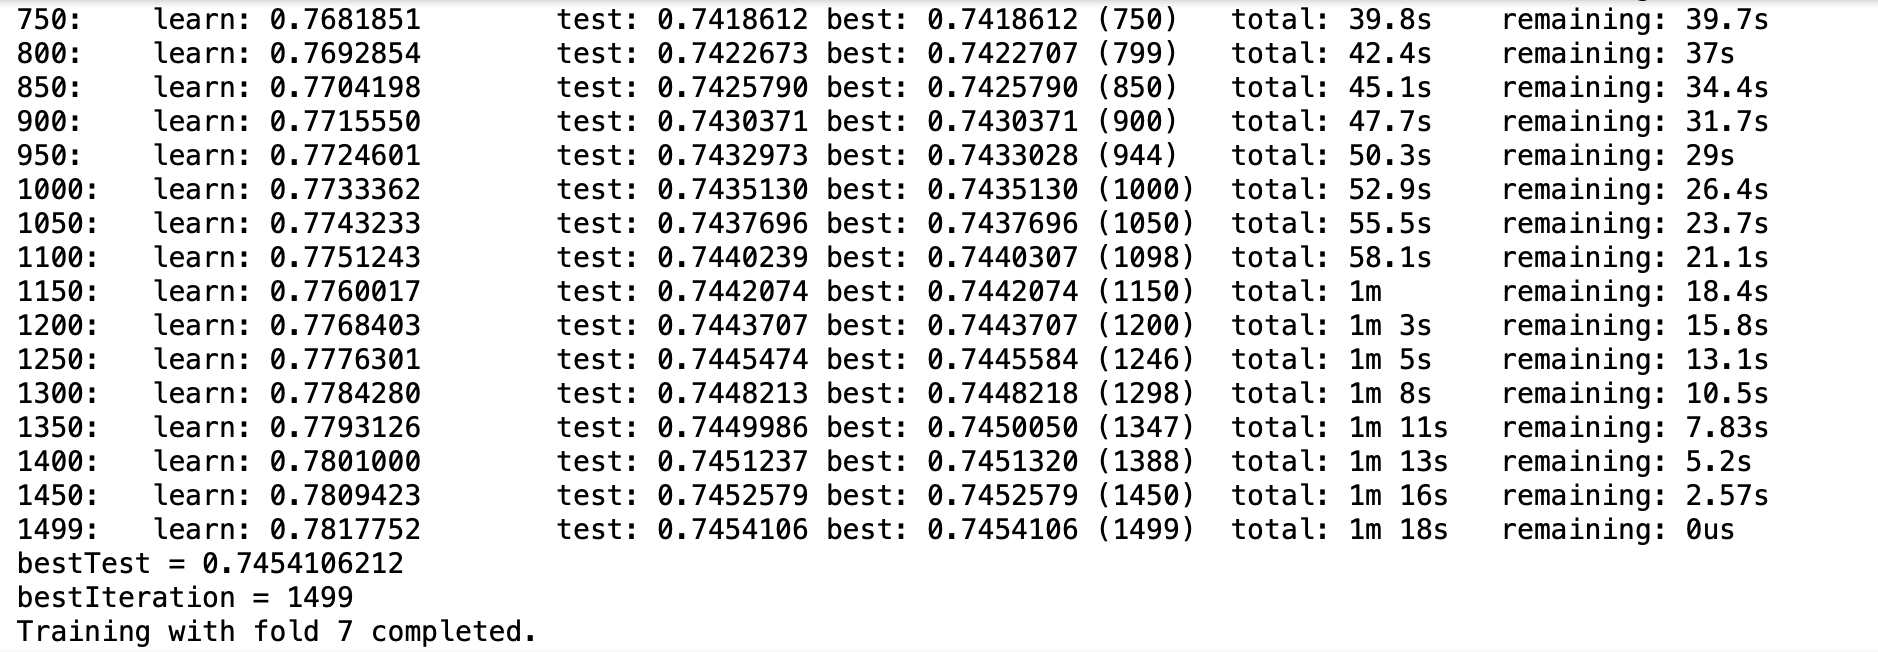

In [ ]:
from sklearn.metrics import roc_auc_score
'Train roc-auc', roc_auc_score(y, train_preds)

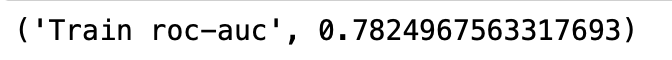

In [ ]:
'CV roc-auc', roc_auc_score(y, oof)

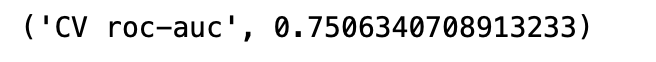

# Test data

* Finally, we can preprocess the test data and make predictions! 

* We need to make a small adjustment to function that reads input files

In [ ]:
list_filenames = !ls "/content/drive/My Drive/test_trans_contest"
all_names_do25 = []
all_names_after_25 = []
for i in range(len(list_filenames)):
    d = list_filenames[i].split()
    all_names_do25.append(d[0])
    all_names_after_25.append(d[1])
all_names = all_names_do25 + all_names_after_25 #list_with_filepaths

def read_file_(path_):
    '''
    More convenient way to read a parquet file
    :param path_: path to file
    :return: pandas DataFrame
    '''
    return pd.read_parquet('/content/drive/My Drive/test_trans_contest/'+ path_)

def make_features(path):
    global file
    global train_target
    file = read_file_(path)
    list_ = reduce_mem_usage()
    file_clean()
    print('Starting doing')
    ration_days_oper()
    has_credit_and_debit_card()
    print('2 functions done')
    count_mean_hour_diff()
    mean_and_var_time_delta()
    print('4 functions done')
    final_nakop()
    counting_means_for_columns()
    print('6 functions done')
    countring_var_for_city_country()
    income_ratio()
    print('8 functions done')
    dollar_and_euro_ratio()
    counting_count_for_columns()
    print('all done')
    gc.collect()
    
    
def make_target(names):
    global file
    global train_target
    for i in tqdm(range(len(all_names))):#len(all_names)
        train_target = pd.read_csv('/content/drive/My Drive/alfabattle2_test_target_contest.csv')
        make_features(names[i])
        train_target.to_csv('file_'+str(i)+'.csv')
        
make_target(all_names)

In [ ]:
################################

## Upload back

In [ ]:
for i in range(len(all_names)):
    if i == 0:
        data = pd.read_csv('file_0.csv', index_col='Unnamed: 0')
    else:
        data = pd.concat([data, pd.read_csv('file_'+str(i)+'.csv', index_col='Unnamed: 0')], axis=0)


In [ ]:
data.fillna(value=0, inplace=True)
data = data.set_index('app_id')
data = pd.concat([pd.get_dummies(data['product']), data.drop(columns='product')], axis=1) #OHE 'product'


<font size="3"> Interesting that in test data there was not a single client with 'payment_system' equal to 6. So, we need to add these 2 features as zeros.</font>

In [ ]:
data['payment_system_6_mean'] = np.zeros(len(data))
data['payment_system_6_count'] = np.zeros(len(data))

* After that, we need to make the right order of features - some of them got mixed.

In [ ]:
f = pd.concat([data[data.columns[:25]], data[data.columns[26:44]], data[data.columns[45:50]], 
           data[['operation_type_group_3_mean', 'operation_type_group_3_count']], data[data.columns[50:]]], axis=1)
data = f

#Apply StandardScaler we used earlier.
scaled_data = pd.DataFrame(column_transformer.transform(data), columns=numeric_features)

index_data = data[not_to_scale].index
scaled_data = scaled_data.set_index(index_data)

data = pd.concat([data[not_to_scale], scaled_data], axis=1)
data

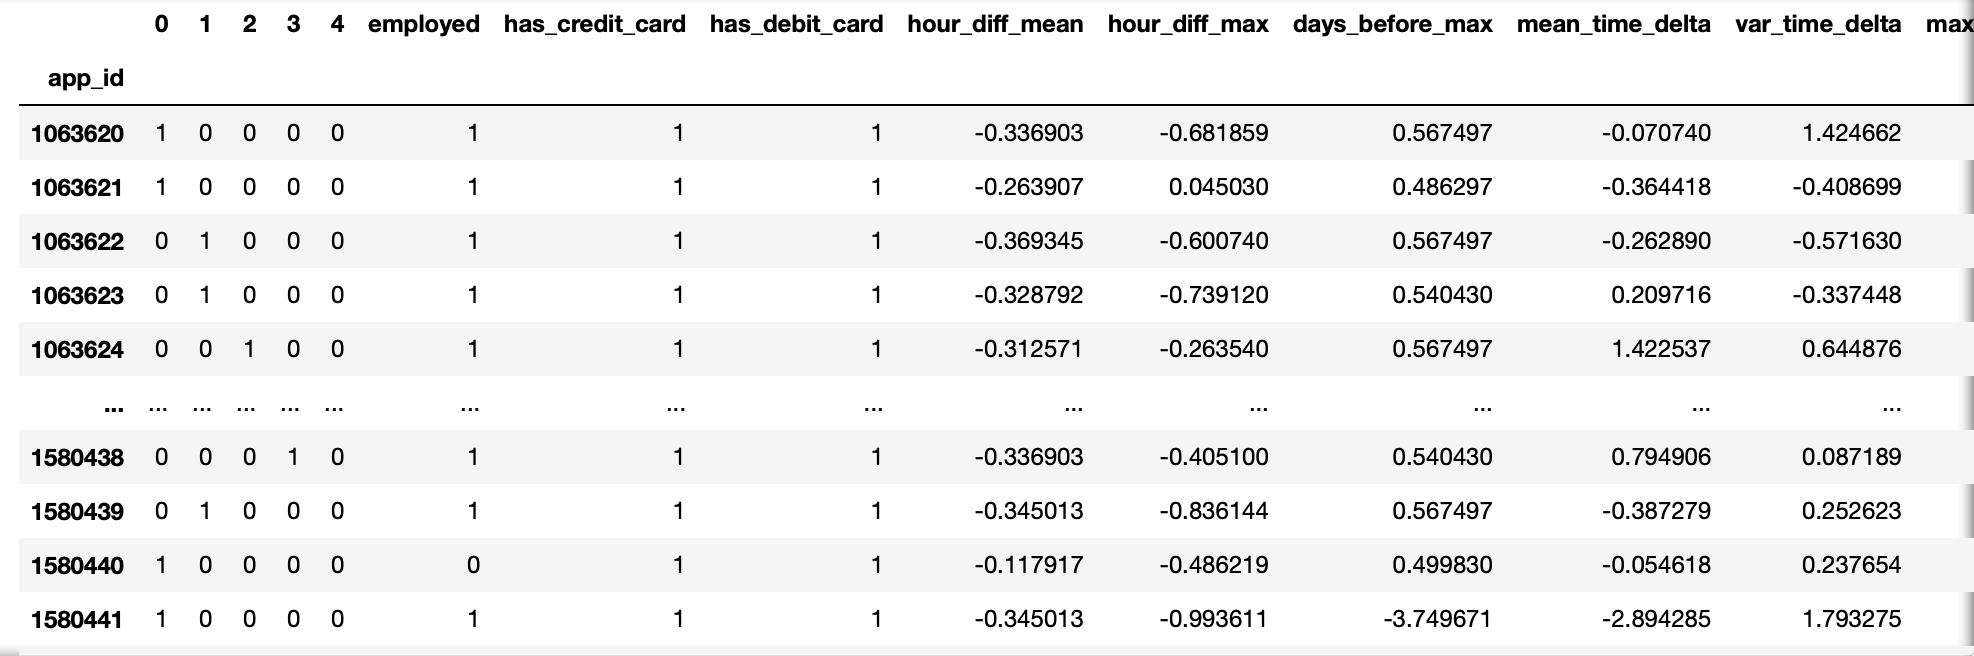

# Time to predict!

* Finally, we make predictions for the test data. I will use all 7 models and apply the mean value of their predictions.

In [ ]:
score = np.zeros(len(data))

for i in tqdm(range(len(models))):
    score += models[i].predict_proba(data)[:, 1] / len(models) #train_target.drop(columns=['flag'])
    
submission = pd.DataFrame({
    'app_id' : data.index.values,
    'score': score})

In [ ]:
submission

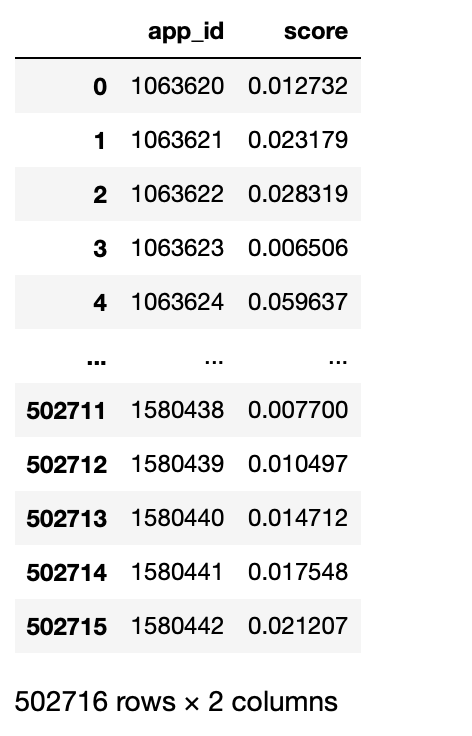